In [8]:
import numpy as np
import seaborn as sns
from tqdm import trange
from scipy.stats import norm
import matplotlib.pyplot as plt

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (15.0, 8.0)

# path params
plot_dir = './plots/'

## Question Prompt

Given the following current equation

$$I(\Delta L, \Delta V_{TH}) = \frac{50}{0.1 + \Delta L} (0.6 - \Delta V_{TH})^2$$

* $\Delta L \sim \ N(0, 0.01^2)$
* $\Delta V_{TH} \sim \ N(0, 0.03^2)$

We would like to calculate $P(I > 275)$ using direct Monte-Carlo and Importance Sampling.

## Direct Monte-Carlo Estimation

In MC estimation, we approximate an integral by the sample mean of a function of simulated random variables. In more mathematical terms,

$$\int p(x)\ f(x)\ dx = \mathbb{E}_{p(x)} \big[\ f(x) \big] \approx \frac{1}{N} \sum_{n=1}^{N}f(x_n)$$

where $x_n \sim \ p(x)$.

A useful application of MC is probability estimation. In fact, we can cast a probability as an expectation using the indicator function. In our case, given that $A = \{I \ | \ I > 275\}$, we define $f(x)$ as

$$f(x) = I_{A}(x)= \begin{cases} 
      1 & I \geq 275 \\
      0 & I < 275 
   \end{cases}$$
   
Replacing in our equation above, we get

$$\int p(x) \ f(x) \ dx = \int I(x)\ p(x) \ d(x) = \int_{x \in A} p(x)\ d(x) \approx \frac{1}{N} \sum_{n=1}^{N}I_{A}(x_n)$$

In [33]:
def monte_carlo_proba(num_simulations, num_samples, verbose=True, plot=False):
    
    if verbose:
        print("===========================================")
        print("{} Monte Carlo Simulations of size {}".format(num_simulations, num_samples))
        print("===========================================\n")
    
    num_samples = int(num_samples)
    num_simulations = int(num_simulations)
    
    probas = []
    for i in range(num_simulations):
        mu_1, sigma_1 = 0, 0.01
        mu_2, sigma_2 = 0, 0.03

        length = np.random.normal(mu_1, sigma_1, num_samples)
        voltage = np.random.normal(mu_2, sigma_2, num_samples)

        num = 50 * np.square((0.6 - voltage))
        denum = 0.1 + length
        I = num / denum
        
        true_condition = np.where(I >= 275)
        false_condition = np.where(I < 275)
        num_true = true_condition[0].shape[0]
        proba = num_true / num_samples
        probas.append(proba)
        
        if plot:
            if i == (num_simulations - 1):
                plt.scatter(length[true_condition], voltage[true_condition], color='r')
                plt.scatter(length[false_condition], voltage[false_condition], color='b')
                plt.xlabel(r'$\Delta L$ [$\mu$m]')
                plt.ylabel(r'$\Delta V_{TH}$ [V]')
                plt.title("Monte Carlo Estimation of P(I > 275)")
                plt.savefig(plot_dir + 'monte_carlo.pdf', format='pdf', dpi=300)
                plt.show()
    
    
    mean_proba = np.mean(probas)
    std_proba = np.std(probas)
    
    if verbose:
        print("Probability Mean: {:0.5f}".format(mean_proba))
        print("Probability Std: {:0.5f}".format(std_proba))
    
    return probas

In [32]:
probas = monte_carlo_proba(10, 10000, plot=False)

10 Monte Carlo Simulations of size 10000

Probability Mean: 0.00215
Probability Std: 0.00054


In [35]:
num_samples = [1e3, 1e4, 1e5, 1e6]
num_repetitions = 25

total_probas = []
for i, num_sample in enumerate(num_samples):
    print("Iter {}/{}".format(i+1, len(num_samples)))
    probas = monte_carlo_proba(num_repetitions, num_sample, verbose=False)
    total_probas.append(probas)

Iter 1/4
Iter 2/4
Iter 3/4
Iter 4/4


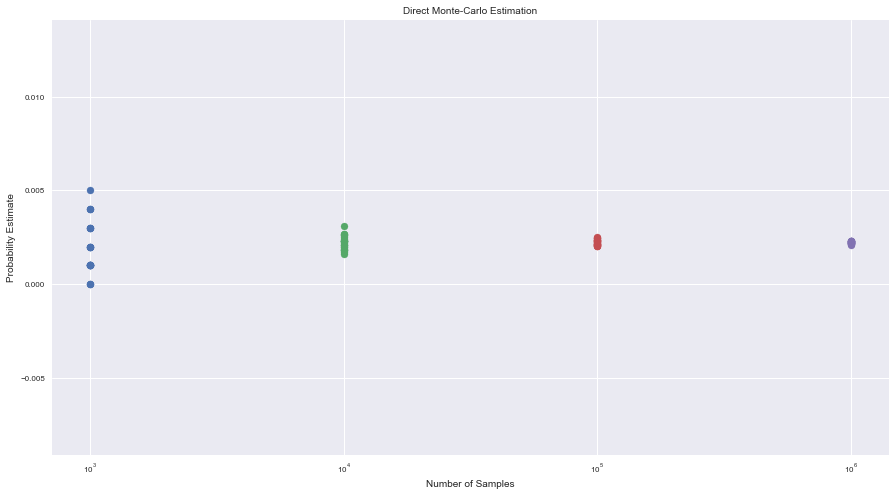

In [45]:
y_axis = np.asarray(total_probas)
x_axis = np.asarray(num_samples)

for x, y in zip(x_axis, y_axis):
    plt.scatter([x] * len(y), y)

plt.xscale('log')
plt.title("Direct Monte-Carlo Estimation")
plt.ylabel("Probability Estimate")
plt.xlabel('Number of Samples')
plt.show()

## Importance Sampling

With importance sampling, we try to reduce the variance of our Monte-Carlo integral estimation by choosing a better distribution from which to simulate our random variables. It involves multiplying the integrand by 1 (usually dressed up in a “tricky fashion”) to yield an expectation of a quantity that varies less than the original integrand over the region of integration. Concretely,

$$\mathbb{E}_{p(x)} \big[\ f(x) \big] = \int f(x)\ p(x)\ dx = \int f(x)\ p(x)\ \frac{q(x)}{q(x)}\ dx = \int \frac{p(x)}{q(x)}\cdot f(x)\ q(x)\ dx = \mathbb{E}_{q(x)}  \big[\ f(x)\cdot \frac{p(x)}{q(x)} \big]$$

Thus, the MC estimation of the expectation becomes:

$$\mathbb{E}_{q(x)}  \big[\ f(x)\cdot \frac{p(x)}{q(x)} \big] \approx \frac{1}{N} \sum_{n=1}^{N} w_n \cdot f(x_n)$$

where $w_n = \dfrac{p(x_n)}{q(x_n)}$

In [51]:
def importance_sampling(num_simulations, num_samples, verbose=True, plot=False):
    
    if verbose:
        print("===================================================")
        print("{} Importance Sampling Simulations of size {}".format(num_simulations, num_samples))
        print("===================================================\n")
    
    num_simulations = int(num_simulations)
    num_samples = int(num_samples)
    
    probas = []
    for i in range(num_simulations):
        mu_1, sigma_1 = 0, 0.01
        mu_2, sigma_2 = 0, 0.03
        mu_1_n, sigma_1_n = 0, 0.02
        mu_2_n, sigma_2_n = 0, 0.06
        
        # setup pdfs
        old_pdf_1 = norm(mu_1, sigma_1)
        new_pdf_1 = norm(mu_1_n, sigma_1_n)
        old_pdf_2 = norm(mu_2, sigma_2)
        new_pdf_2 = norm(mu_2_n, sigma_2_n)

        length = np.random.normal(mu_1_n, sigma_1_n, num_samples)
        voltage = np.random.normal(mu_2_n, sigma_2_n, num_samples)
        
        # calculate current
        num = 50 * np.square((0.6 - voltage))
        denum = 0.1 + length
        I = num / denum
        
        # calculate f
        true_condition = np.where(I >= 275)

        # calculate weight
        num = old_pdf_1.pdf(length) * old_pdf_2.pdf(voltage)
        denum = new_pdf_1.pdf(length) * new_pdf_2.pdf(voltage)
        weights = num / denum

        # select weights for nonzero f
        weights = weights[true_condition]

        # compute unbiased proba
        proba = np.sum(weights) / num_samples
        probas.append(proba)
        
        false_condition = np.where(I < 275)
        if plot:
            if i == num_simulations -1:
                plt.scatter(length[true_condition], voltage[true_condition], color='r')
                plt.scatter(length[false_condition], voltage[false_condition], color='b')
                plt.xlabel(r'$\Delta L$ [$\mu$m]')
                plt.ylabel(r'$\Delta V_{TH}$ [V]')
                plt.title("Monte Carlo Estimation of P(I > 275)")
                plt.savefig(plot_dir + 'imp_sampling.pdf', format='pdf', dpi=300)
                plt.show()
    
    
    mean_proba = np.mean(probas)
    std_proba = np.std(probas)
    
    if verbose:
        print("Probability Mean: {}".format(mean_proba))
        print("Probability Std: {}".format(std_proba))
    
    return probas

In [50]:
probas = importance_sampling(10, 10000, plot=False)

10 Importance Sampling Simulations of size 10000

Probability Mean: 0.0022377303080329774
Probability Std: 0.00012717556558219492


In [52]:
num_samples = [1e3, 1e4, 1e5, 1e6]
num_repetitions = 25

total_probas = []
for i, num_sample in enumerate(num_samples):
    print("Iter {}/{}".format(i+1, len(num_samples)))
    probas = importance_sampling(num_repetitions, num_sample, verbose=False)
    total_probas.append(probas)

Iter 1/4
Iter 2/4
Iter 3/4
Iter 4/4


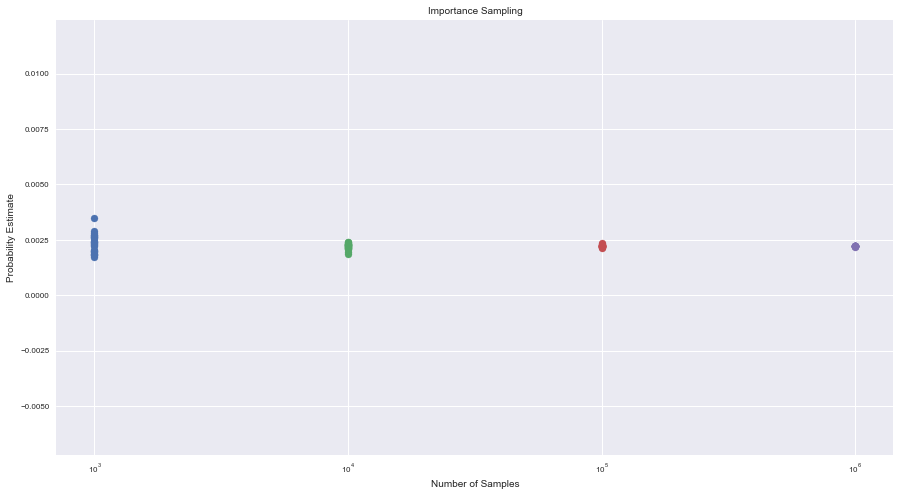

In [53]:
y_axis = np.asarray(total_probas)
x_axis = np.asarray(num_samples)

for x, y in zip(x_axis, y_axis):
    plt.scatter([x] * len(y), y)
    
plt.xscale('log')
plt.title("Importance Sampling")
plt.ylabel("Probability Estimate")
plt.xlabel('Number of Samples')
plt.show()